# Lead sets

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wandb
import pandas as pd
import os
import ast
import warnings
from tqdm import tqdm
from torch.utils.data import DataLoader
from omegaconf import OmegaConf
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap
from src.modeling.siglabv2.siglabv2 import SigLabV2, BlindSigLabV2
from src.modeling.siglabv2.siglab_nocontext import SigLabNoContext
from src.modeling.siglabv2.siglab_deepsets import SigLabDeepsets
from src.modeling.datasets.siglab_dataset import SigLabDataset
from src.run import lead_sets
from src.utils import count_parameters, confusion_matrix, apply_preprocessors, PRECORDIAL_LEAD_NAMES, hungarian_predictions
from src.evaluation import lead_level_accuracy, set_level_accuracy
from src.data.load_ptbdata_new import PRECORDIAL_LEADS, LIMB_LEADS, AUGMENTED_LEADS, ALL_LEADS

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

plt.rcParams.update({ "font.family": "serif", "font.serif": ["Times New Roman"], "mathtext.fontset": "cm"}) # for math symbols })

2025-06-01 15:36:36.670 | INFO     | bachelors_thesis.config:<module>:11 - PROJ_ROOT path is: C:\Users\natem\bachelors_thesis


In [3]:
data = pd.read_csv('resources/lead_set_comparison_2.csv')
# Remove the first row
data = data.iloc[1:]
data.head()

,precordial,I,I-III,aVF,All 12
1,0.934415,0.918962,0.894897,0.906849,0.883501
2,0.944032,0.932725,0.934046,0.937338,0.904505
3,0.952631,0.942502,0.934842,0.934651,0.912975
4,0.954824,0.952386,0.946092,0.948908,0.935243
5,0.957150,0.952003,0.944935,0.948432,0.923539


In [2]:
run_ids = [
    "qawus9eh",
    "y79dz973",
    "no64sfwm",
    "736ha4nl",
    "2sp92xaw",
    "u8k98a00"
]

versions = [
    "v24",
    "latest",
    "v19",
    "v21",
    "v20",
    "v20"
]

labels = [
    "III,V1-V6",
    "II,V1-V6",
    "V1-V6",
    "aVF",
    "All 12 Leads",
    "I,aVF"
]


In [16]:
project_path = "nateml-maastricht-university/bachelors-thesis"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the torch model from wandb

api = wandb.Api()

all_logits = []
all_targets = []

run_id = run_ids[5]  # Change this to the desired run ID
version = versions[5]  # Change this to the desired version

run = api.run(f"{project_path}/{run_id}")
config = dict(run.config)

# Get the run name
run_name = run.name

artifact = api.artifact(f"{project_path}/{run_name}:{version}")
artifact_path = artifact.download()

# Convert config to omegaconf
cfg = OmegaConf.create(config)

# Load the model
checkpoint = torch.load(artifact_path + f"/{run_name}.pth", map_location=device)

# Cast the model to the correct type
model = SigLabV2(cfg.model).to(device)
model.load_state_dict(checkpoint)
model.eval()  # Put into evaluation mode

# Save the model to a file
model_path: Path = Path("../../models/lead-set-models/")
# Save the whole model
torch.save(model, (model_path / 'model').with_suffix('.pth'))
# Save the model state dict
torch.save(model.state_dict(), (model_path / 'state_dict').with_suffix('.pth'))
# Save the config
OmegaConf.save(cfg, (model_path / 'config').with_suffix('.yaml'))

# Save text file with the run ID and version
with open((model_path / 'wandb').with_suffix('.txt'), 'w') as f:
    f.write(f"WandB Run ID: {run_id}\n")
    f.write(f"Artifact Version: {version}\n")

wandb:   1 of 1 files downloaded.  


In [3]:
project_path = "nateml-maastricht-university/bachelors-thesis"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the torch model from wandb

api = wandb.Api()

all_logits = []
all_targets = []

for run_id, version, name in zip(run_ids, versions, labels):
    run = api.run(f"{project_path}/{run_id}")
    config = dict(run.config)

    # Get the run name
    run_name = run.name

    artifact = api.artifact(f"{project_path}/{run_name}:{version}")
    artifact_path = artifact.download()

    # Convert config to omegaconf
    cfg = OmegaConf.create(config)

    # Load the model
    checkpoint = torch.load(artifact_path + f"/{run_name}.pth", map_location=device)

    # Cast the model to the correct type
    model = SigLabV2(cfg.model).to(device)
    model.load_state_dict(checkpoint)
    model.eval()  # Put into evaluation mode

    dataset_path = Path("../../" + cfg.dataset.path)
    if OmegaConf.select(cfg, "dataset.only_precordial"):
        dataset_path = dataset_path / "precordial"
    else:
        dataset_path = dataset_path / "all"
    dataset_path = dataset_path.resolve()

    test_data = np.load(dataset_path / "test.npy")

    # Apply preprocessors
    test_data = apply_preprocessors(test_data,
                                    cfg.dataset.sampling_rate,
                                    cfg.preprocessor_group.preprocessors)
    
    # Convert to torch tensor
    test_data = torch.from_numpy(test_data).float().to(device)
    test_data = test_data.permute(0, 2, 1)

    # Create the dataset and dataloader
    lead_filter = lead_sets[OmegaConf.select(cfg, "run.leads", default="precordial")]
    dataset = SigLabDataset(test_data, filter_leads=lead_filter)
    batch_size = 32
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=False)

    # I need to reorder val_data to match the order of the labels in the dataset
    if OmegaConf.select(cfg, "dataset.only_precordial") or OmegaConf.select(cfg, "dataset.only_precordial") is None:
        test_data = test_data[:, [PRECORDIAL_LEADS.index(lead) for lead in lead_filter], :]
    else:
        test_data = test_data[:, [ALL_LEADS.index(lead) for lead in lead_filter], :]

    # Load metadata
    meta_val = pd.read_csv(dataset_path / "meta_val.csv")
    meta_test = pd.read_csv(dataset_path / "meta_test.csv")
    meta = meta_test.copy()
    meta['scp_codes'] = meta['scp_codes'].apply(lambda x: ast.literal_eval(x))

    THRESHOLD = 0.5
    def codes_above_threshold(code_dict, thr=THRESHOLD):
        return {code for code, prob in code_dict.items() if prob >= thr}

    meta["present_codes"] = meta["scp_codes"].apply(lambda x: codes_above_threshold(x, THRESHOLD))

    # Treat diagnostic superclass as lists
    meta["diagnostic_superclass"] = meta["diagnostic_superclass"].apply(lambda x: ast.literal_eval(x))
    # Now convert to a set
    meta["diagnostic_superclass"] = meta["diagnostic_superclass"].apply(lambda x: set(x))

    c = 6
    # I only care about the precordial leads
    logits = np.zeros((len(dataset), c, cfg.model.num_classes))
    targets = np.zeros((len(dataset), c))
    predictions = np.zeros((len(dataset), c))

    for idx, (signals, lead_labels) in enumerate(tqdm(dataloader)):
        signals = signals.to(device)
        lead_labels = lead_labels.to(device)
        lead_labels = lead_labels[:, 0:6]

        # Make predictions
        with torch.no_grad():
            these_logits = model(signals)
            # Extract precordial leads
            if idx == 0:
                print(these_logits.shape)
            these_logits = these_logits[:, 0:6]

            logits[(idx * batch_size):(idx * batch_size + batch_size)] = these_logits.cpu().numpy()
            targets[(idx * batch_size):(idx * batch_size + batch_size)] = lead_labels.cpu().numpy()

    all_logits.append(logits)
    all_targets.append(targets)
    predictions = logits.argmax(axis=-1)

    # Calculate lead and set level accuracies
    lead_acc = lead_level_accuracy(predictions=predictions, targets=targets, return_ci=True, alpha=0.05, method="bootstrap", R=10000)
    set_acc = set_level_accuracy(predictions=predictions, targets=targets, return_ci=True, alpha=0.05, method="wilson")

    print(f"Run: {run_name}, Lead Acc: {lead_acc[0]:.3f} [{lead_acc[1]:.3f}, {lead_acc[2]:.3f}], Set Acc: {set_acc[0]} [{set_acc[1]:.3f}, {set_acc[2]:.3f}]")

wandb:   1 of 1 files downloaded.  
  6%|▌         | 4/69 [00:00<00:07,  8.57it/s]

torch.Size([32, 9, 9])


100%|██████████| 69/69 [00:03<00:00, 21.09it/s]


Run: 108_siglabv2_limb, Lead Acc: 0.979 [0.975, 0.982], Set Acc: 0.9363057324840764 [0.925, 0.946]


wandb:   1 of 1 files downloaded.  
  4%|▍         | 3/69 [00:00<00:05, 13.05it/s]

torch.Size([32, 7, 7])


100%|██████████| 69/69 [00:02<00:00, 33.29it/s]


Run: 82_siglabv2_II, Lead Acc: 0.978 [0.975, 0.982], Set Acc: 0.9381255686988171 [0.927, 0.947]


wandb:   1 of 1 files downloaded.  
  3%|▎         | 2/69 [00:00<00:05, 13.06it/s]

torch.Size([32, 6, 6])


100%|██████████| 69/69 [00:02<00:00, 31.29it/s]


Run: 109_siglabv2_precordial, Lead Acc: 0.977 [0.973, 0.981], Set Acc: 0.9340309372156506 [0.923, 0.944]


wandb:   1 of 1 files downloaded.  
  1%|▏         | 1/69 [00:00<00:07,  9.08it/s]

torch.Size([32, 7, 7])


100%|██████████| 69/69 [00:02<00:00, 29.39it/s]


Run: 103_siglabv2_aVF, Lead Acc: 0.977 [0.973, 0.981], Set Acc: 0.9340309372156506 [0.923, 0.944]


wandb:   1 of 1 files downloaded.  
  1%|▏         | 1/69 [00:00<00:13,  4.92it/s]

torch.Size([32, 12, 12])


100%|██████████| 69/69 [00:03<00:00, 18.66it/s]


Run: 106_siglabv2_all-precordialoptimised, Lead Acc: 0.976 [0.972, 0.980], Set Acc: 0.924476797088262 [0.913, 0.935]


wandb:   1 of 1 files downloaded.  
  4%|▍         | 3/69 [00:00<00:02, 23.63it/s]

torch.Size([32, 8, 8])


100%|██████████| 69/69 [00:02<00:00, 27.14it/s]


Run: 110_siglabv2_I-aVF, Lead Acc: 0.976 [0.972, 0.980], Set Acc: 0.9317561419472248 [0.920, 0.942]


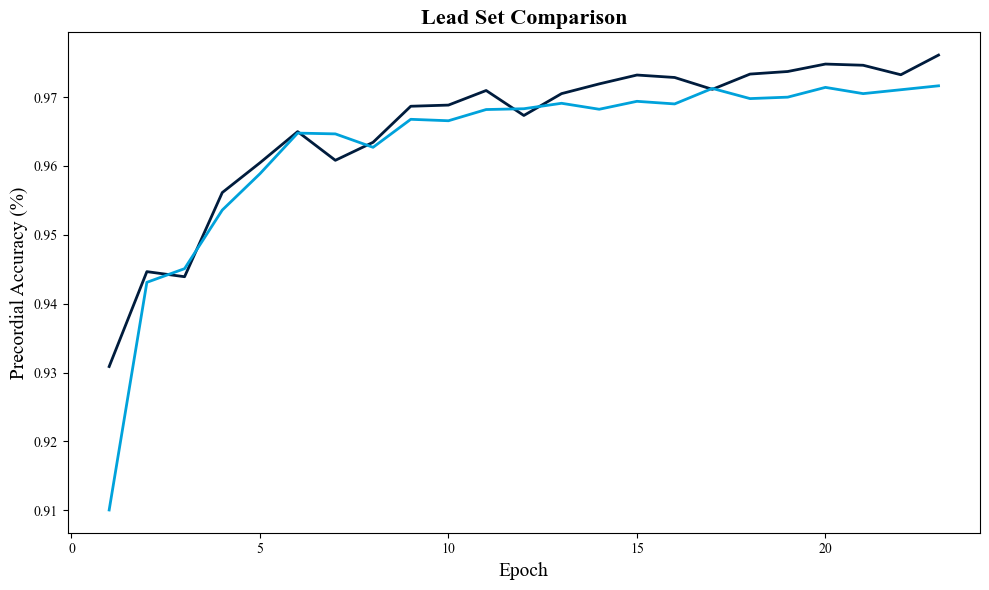

In [ ]:
# Plot as line plot
dark_blue = '#001C3D'
light_blue = '#00A2DB'
orange_red = '#E84E10'
orange = '#F39425'

plt.figure(figsize=(10, 6))
plt.plot(data.index, data['precordial'], color=dark_blue, label='Precordial', linewidth=2)
plt.plot(data.index, data['I'], color=light_blue, label='Inferior', linewidth=2)

# Plot settings
plt.title('Lead Set Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Precordial Accuracy (%)', fontsize=14)

plt.tight_layout()
plt.show()

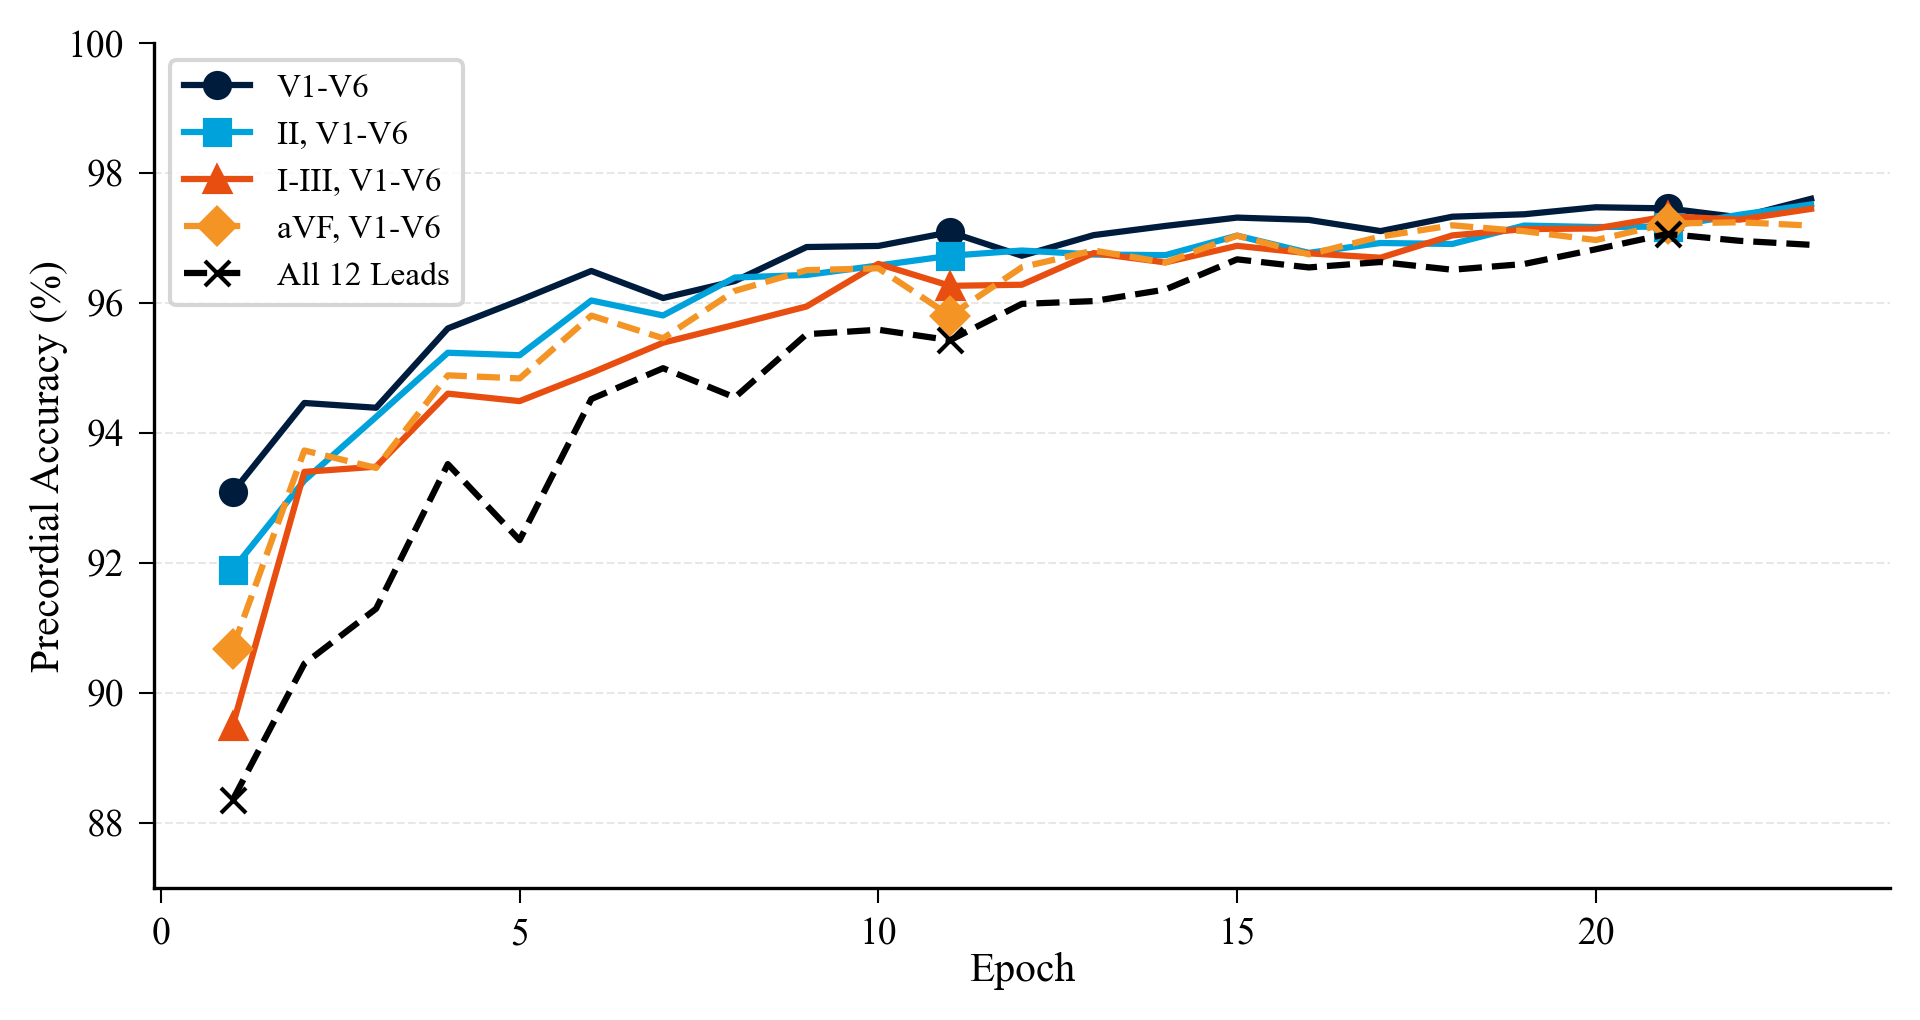

In [30]:
# ── MU colour palette ──────────────────────────────────────────────
dark_blue  = "#001C3D"   # primary
light_blue = "#00A2DB"   # accent
orange_red = "#E84E10"   # accent
orange     = "#F39425"   # accent

# ── (demo) dummy data – remove when you have the real df ──────────
# epochs 0 … 99, two accuracy curves
# data = pd.DataFrame({
#     "precordial": np.random.normal(80, 2, 100).cumsum() / np.arange(1, 101),
#     "inferior":   np.random.normal(78, 2, 100).cumsum() / np.arange(1, 101),
# })
# data.index.name = "epoch"
# ───────────────────────────────────────────────────────────────────

# ── Global font to match previous plots ────────────────────────────
plt.rcParams.update({
    "font.family": "serif",
    "font.serif":  ["Times New Roman", "CMU Bright"],  # falls back if CMU missing
    "mathtext.fontset": "cm",
})

# ── Figure ────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6.5, 3.5), dpi=300)

ax.plot(data.index, data["precordial"]*100,
        label="V1-V6", color=dark_blue,  linewidth=1.5, marker="o", markevery=10)
ax.plot(data.index, data["I"]*100,
        label="II, V1-V6",   color=light_blue, linewidth=1.5, marker="s", markevery=10)
ax.plot(data.index, data["I-III"]*100,
        label="I-III, V1-V6", color=orange_red, linewidth=1.5, marker="^", markevery=10)
ax.plot(data.index, data["aVF"]*100,
        label="aVF, V1-V6",  color=orange, linewidth=1.5, marker="D", markevery=10,
        linestyle="--")
ax.plot(data.index, data["All 12"]*100,
        label="All 12 Leads", color="black", linewidth=1.5, marker="x", markevery=10,
        linestyle="--")

# Axis labels & limits
ax.set_xlabel("Epoch", fontsize=10, fontweight="regular", labelpad=0)
ax.set_ylabel("Precordial Accuracy (%)", fontsize=10, fontweight="regular", labelpad=0)
ax.set_ylim(87, 100)
#ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

# Title
#ax.set_title("Precordial Validation Accuracy When Training On Different Lead Sets",
             #fontsize=12, fontweight="regular", pad=16)

# Grid & spines
ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.3)
ax.spines[["top", "right"]].set_visible(False)

# Legend (outside, matching earlier style)
ax.legend(fontsize=8)
for text in ax.legend_.get_texts():
        text.set_fontname("Times New Roman")
        text.set_fontweight("regular")

# Tick styling
ax.tick_params(axis="both", labelsize=9, width=0.5)

plt.tight_layout()
plt.savefig("lead_set_comparison.pdf", bbox_inches="tight")
plt.savefig("lead_set_comparison.png", dpi=400, bbox_inches="tight")
plt.show()

# McNemar's Test

In [16]:
# Perform McNemar's test for each lead set against the precordial leads
from statsmodels.stats.contingency_tables import mcnemar

def mcnemar_test(predictions_a, predictions_b, targets):

    # Flatten the predictions and targets
    predictions_a = predictions_a.flatten()
    predictions_b = predictions_b.flatten()
    targets = targets.flatten()

    correct_a = predictions_a == targets
    correct_b = predictions_b == targets

    n10 = np.sum(correct_a & ~correct_b)  # A correct, B incorrect
    n01 = np.sum(~correct_a & correct_b)  # A incorrect, B correct

    print(f"n10: {n10}, n01: {n01}")

    # Perform McNemar's test
    result = mcnemar([[0, n01], [n10, 0]], exact=False)
    
    return result.statistic, result.pvalue

precordial_model_idx = 2
alpha = 0.05
# Compare each lead set against the precordial leads
precordial_preds = all_logits[precordial_model_idx].argmax(axis=-1)
for i, (logits, targets, name) in enumerate(zip(all_logits, all_targets, labels)):
    if i == precordial_model_idx:
        continue  # Skip the precordial model itself

    preds = logits.argmax(axis=-1)
    statistic, pvalue = mcnemar_test(predictions_a=precordial_preds,
                                      predictions_b=preds,
                                      targets=targets)

    # Calculate delta accuracy
    delta_accuracy = (preds == targets).mean() - (precordial_preds == targets).mean()
    print(f"Precordial vs {name} - Delta Accuracy: {delta_accuracy:.3f}, Statistic: {statistic:.4f}, p-value: {pvalue:.4f}")

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x0000020D9641E620>> (for pre_run_cell):
